# V.1 Exploring the green reds

### a) Funciton to display the Scatter Plot Matrix

In [21]:
import numbers
import math
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


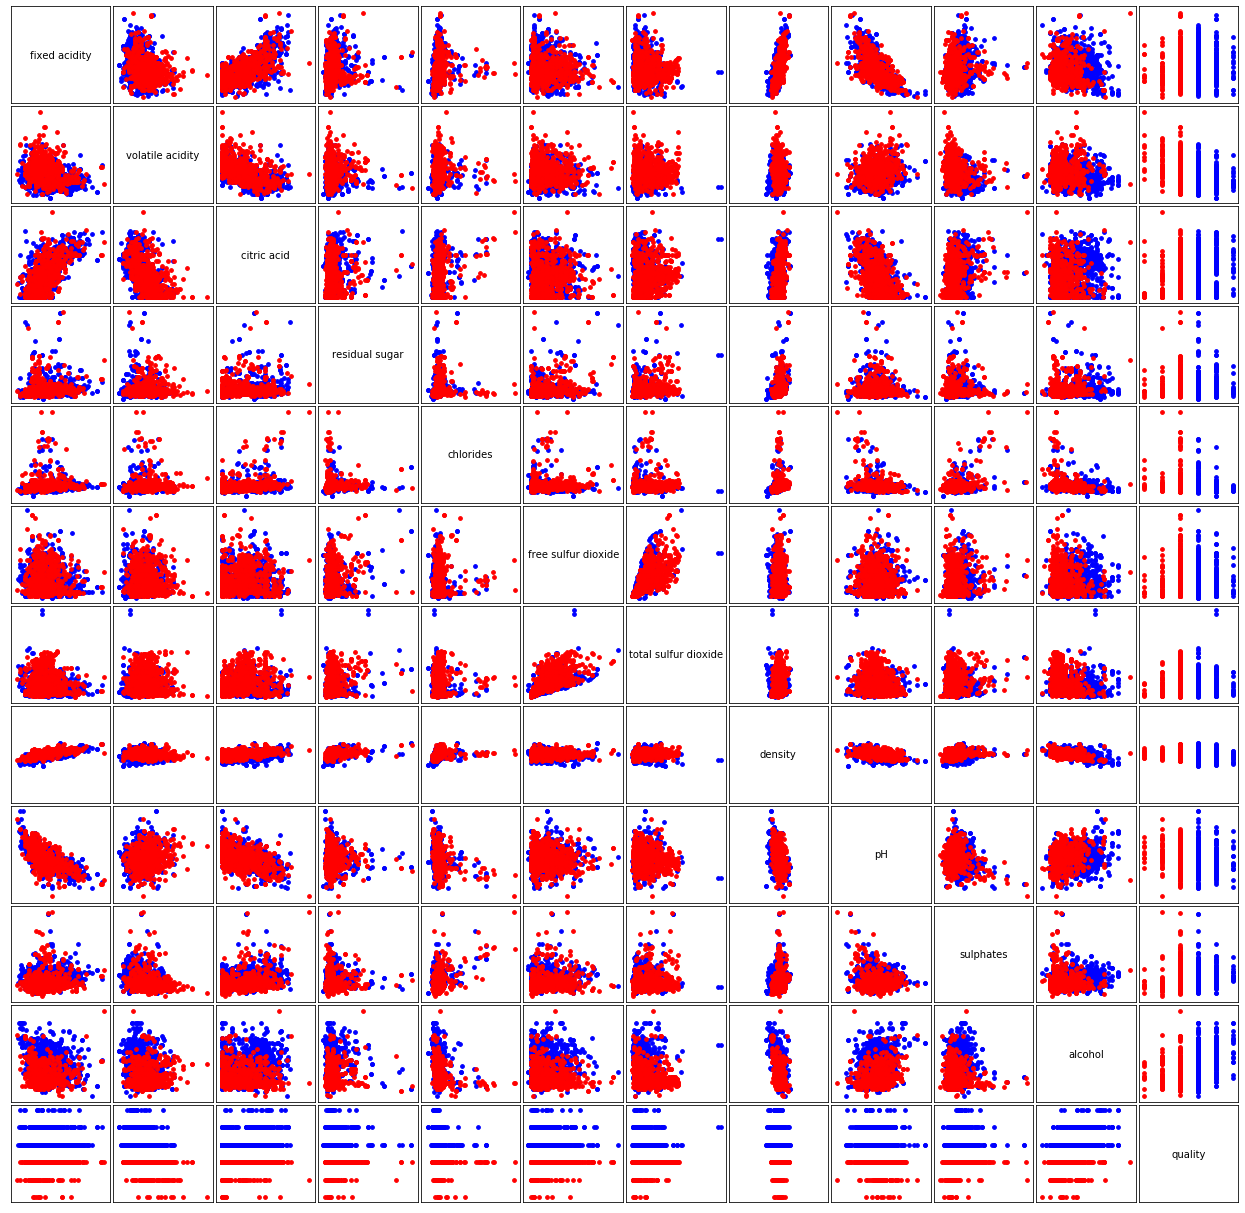

In [37]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, *,
                        save_plot=False, plot_filename='scatterplot_matrix'):
    """
    Plot the Scatter Matrix for wine data.
    If shows relations between each pair of wine parameters.

    Parameters:
        wine_data: Pandas Data Frame, chemical elements and quality of wine.
        good_threshold: quality of good wines.
        bad_threshold: quality of bad wines.
        save_plot: save scatter matrix as .png if True.
        plot_filename: filename for saved photo.
    Return:
        figure with plotted scatter matrix on it.

    """
    rows, cols = wine_data.shape
    fig, axes = plt.subplots(nrows=cols, ncols=cols, figsize=(22, 22))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)
    good_wines = wine_data[wine_data['quality'] >= good_threshold]
    bad_wines = wine_data[wine_data['quality'] <= bad_threshold]
    good_wine_color = "blue"
    bad_wine_color = "red"

    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    for i in range(cols):
        for j in range(i + 1, cols):
            axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], c=good_wine_color, s=14)
            axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], c=bad_wine_color, s=14)
            axes[j, i].scatter(good_wines.iloc[:, i], good_wines.iloc[:, j], c=good_wine_color, s=14)
            axes[j, i].scatter(bad_wines.iloc[:, i], bad_wines.iloc[:, j], c=bad_wine_color, s=14)

    for i, label in enumerate(wine_data.columns):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                           ha='center', va='center')

    if save_plot:
        fig.savefig("{}.png".format(plot_filename))

    return fig

fig = plot_scatter_matrix(red_wine, 6, 5, save_plot=True, plot_filename='red_wine_scatter_matrix')

### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines?
I think, the best factors for distinguishing are:
* Alcohol
* Sulphates
* Volatile Acidity

And the worst factors:
* Residual sugar
* Free sulfur dioxide

# V.2 Learning to perceptron

### a) Implement a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
* Utilizes the heaviside step activation function (discrete version)

### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
* Have a way to specify number of training epochs
* Train your perceptron until it makes no errors, if training epochs is set to 0,
* Have a way to specify learning rate.
* Return a list of python tuples containing (performance):

In [39]:
def dot(a, b):
    if isinstance(b, numbers.Integral) or isinstance(b, numbers.Real):
        return [ai * b for ai in a]
    elif len(a) != len(b):
        raise ValueError("a's and b's lengths must be equal.")
    return sum(ai * bi for ai, bi in zip(a, b))        

def train_split(wine_data, feature_list, good_threshold=8, bad_threshold=3, *, binary=True):
    """Split the wine data into feature list and quality list.
    The quality is replaced with 1 if wine's quality >= good_threshold
    and with -1 or 0 if it's <= bad_threshold

    Parameters:
        wine_data: Pandas Data Frame, chemical elements and quality of wine.
        feature_list: list, containing feature column names.
        good_threshold, quality of good wines.
        bad_threshold, quality of bad wines.
        binary, replaces the quality of bad wines with 0 or -1 if True or False respectively.
    Return:
        Tuple, containing features data and answers.
    
    """
    test_data = wine_data[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
    test_data = test_data.reset_index(drop=True)
    test_data.loc[test_data['quality'] <= bad_threshold, 'quality'] = 0.0 if binary else -1.0
    test_data.loc[test_data['quality'] >= good_threshold, 'quality'] = 1.0
    X = test_data.loc[:, feature_list]
    y = test_data.loc[:, 'quality']
    return X.values, y.values

In [46]:
class Perceptron:
    def __init__(self, learning_rate, *, epochs=0, seed=999):
        """
        Parameters:
            learning_rate: speed of weights updating, must be from 0 to 0.5.
            epochs: if 0 then fit works untill it finds the perfect solution.
            seed: random seed for random function.

        """
        if epochs < 0:
            raise ValueError("Epochs must be more than or equal to zero")
        self._w = None
        self.lr = learning_rate
        if not 0 < self.lr <= 0.5:
            raise ValueError("Learning rate must be more than 0 and less than or equal to 0.5")
        self.epochs = epochs
        self.performance = []
        random.seed(seed)
        
    def fit(self, X, y):
        """Train perceptron.

        Parameters:
            X: array with wine chemical elements
            y: vector with qualities equal to 1 if wine is good, otherwise 0
        Return:
            list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)

        """
        epoch = 0
        self.performance.clear()
        self._w = [random.uniform(-1, 1) for _ in range(X.shape[1] + 1)]
        while epoch < self.epochs or self.epochs == 0:
            epoch_errors = 0
            for xi, target in zip(X, y):
                prediction = self.predict(xi)
                error = target - prediction
                self._w[0] += (self.lr * error)
                self._w[1:] += (self.lr * error * xi)
                epoch_errors += int(error != 0)
            self.performance.append((epoch, epoch_errors, self._w[1:], self._w[0]))
            if self.epochs == 0 and epoch_errors == 0:
                break
            epoch += 1
        return self.performance
    
    def get_accuracy(self, X, y):
        errors = 0
        for xi, target in zip(X, y):
            errors += int(self.predict(xi) != target)
        return errors
    
    def _net_input(self, X):
        return dot(self._w[1:], X) + self._w[0]
    
    def _activation(self, X):
        """Unit step activation function"""
        return 1.0 if self._net_input(X) >= 0 else 0.0
    
    def predict(self, X):
        return self._activation(X)

In [48]:
X, y = train_split(red_wine, ('alcohol', 'volatile acidity'), good_threshold=8, bad_threshold=3)
perceptron = Perceptron(0.1, epochs=0)
performance = perceptron.fit(X, y)

### c) Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works.
Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
* The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
* The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
* Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [61]:
def plot_decision_boundary(ax, stat, wine_data, feature_list, good_threshold, bad_threshold, epoch):
    """Plot Decision Boundary.
    It creates a graph with 2 axes(2 features).
    Then it plots this data as a scatter matrix.
    Weights, which perceptron found during its training, represents the line from (x:0, y:0 + bias) to (x:w1, y:w2).
    And that line is perpendicular to the line, which divides the wine into bad and good.

    Parameters:
        ax: Matplotlib Axis, onto which the decision boundary is plotted.
        stat: a performance list of tuples, regrouped to lists with separated params in each column.
        wine_data: Pandas Data Frame, should contain only good and bad wines.
        feature_list: sequence of 2 feature names.
        good_threshold: quality of good wines.
        bad_threshold: quality of bad wines.
        epoch: number of epoch, for which performance is plotted, if < 0 then the last epoch is plotted.

    """
    feature_x, feature_y = tuple(feature_list)
    x_min = wine_data[feature_x].min()
    x_max = wine_data[feature_x].max()
    y_min = wine_data[feature_y].min()
    y_max = wine_data[feature_y].max()
    good_wines = wine_data[wine_data['quality'] >= good_threshold]
    bad_wines = wine_data[wine_data['quality'] <= bad_threshold]
    w1, w2 = stat[2][epoch]
    b = stat[3][epoch]
    slope = -(b / w2) / (b / w1)
    y_intercept = -b / w2
    
    x = (math.floor(x_min) - 1, math.ceil(x_max) + 2)
    y = [slope * xi + y_intercept for xi in x]
    
    ax.set_xlim(x_min - 0.1, x_max + 0.1)
    ax.set_ylim(y_min - 0.1, y_max + 0.1)
    ax.set_title(f"Decision boundary on epoch: {epoch}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

    ax.plot(x, y, c='magenta', linestyle='--', label='Decision Boundary')
    ax.scatter(good_wines.loc[:, feature_x], good_wines.loc[:, feature_y], s=120, c='blue', marker='s')
    ax.scatter(bad_wines.loc[:, feature_x], bad_wines.loc[:, feature_y], s=120, c='orange', marker='^')
    ax.fill_between(x, y, y_max + 0.1, color='cyan', alpha=0.4, label=f'Good Wines (>= {good_threshold})')
    ax.fill_between(x, y, y_min - 0.1, color='yellow', alpha=0.4, label=f'Bad Wines (<= {bad_threshold})')
    ax.legend(loc='best')

def plot_performance(performance, wine_data, features_list, good_threshold, bad_threshold, *, epoch=-1,
                     save_plot=False, plot_filename='plot_performance'):
    """Plot Perceptron or Adaline performance.
    
    Parameters:
        performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
        wine_data: Pandas Data Frame, chemical elements and quality for wine.
        features_list: list, containing 2 features, used to predict quality.
        good_threshold: quality of good wines.
        bad_threshold: quality of bad wines.
        epoch: default < =, epoch to show decision boundary for. Should be < 0 to show the last epoch.
        save_plot: save scatter matrix as .png if True.
        plot_filename: filename for saved photo.

    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
    stat = list(zip(*performance))
    if epoch < 0:
        epoch = len(stat[0]) - 1

    axes[0].set_title("Errors per epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Errors")
    axes[0].plot(stat[0], stat[1], color='brown')
    
    plot_decision_boundary(axes[1], stat, wine_data, features_list, good_threshold, bad_threshold, epoch)

    if save_plot:
        fig.savefig('{}.png'.format(plot_filename))
    return fig

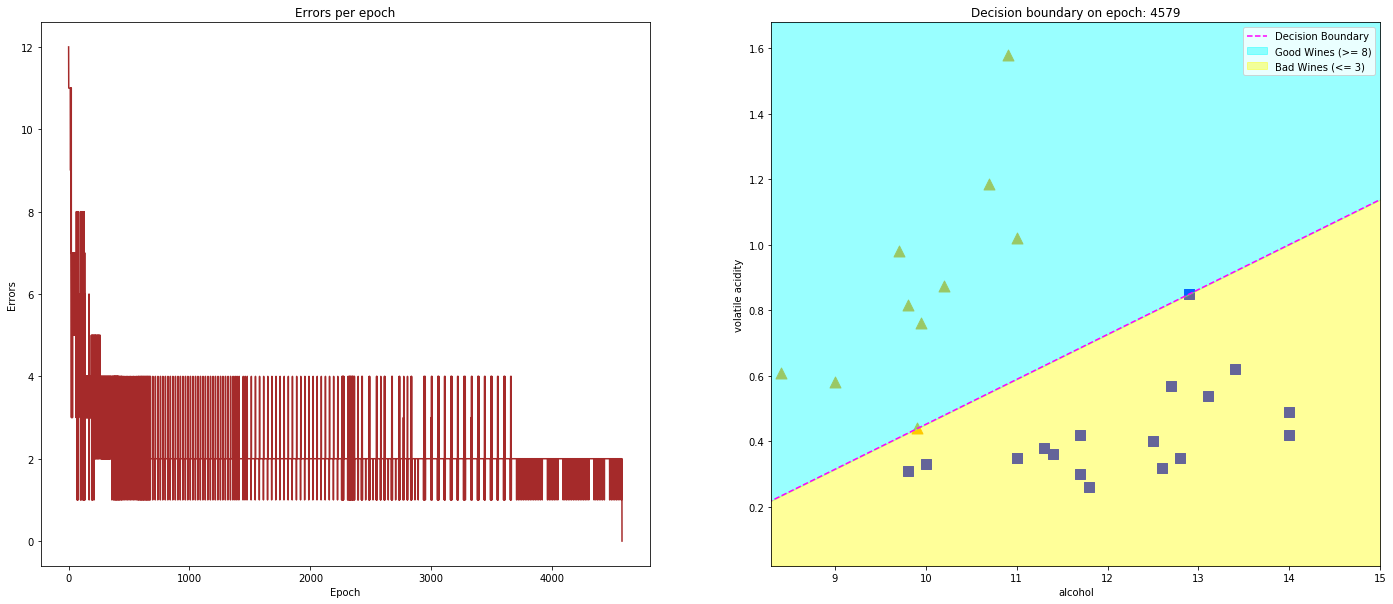

In [62]:
fig = plot_performance(performance, red_wine, ('alcohol', 'volatile acidity'), 8, 3,
                       save_plot=True, plot_filename='perceptron_performance')

### d) Your perceptron appears to work. . . but why is it taking so many epochs to train?
Maybe you can modify the red wine data to help the perceptron learn more quickly?
Use the function you just created in part c) to plot and verify that your
perceptron is learning more efficiently!

In [63]:
def features_scale(wine_data):
    """Scales the wine data using min-max scaling."""
    scaled_data = wine_data.copy()
    for feature in scaled_data.columns:
        if feature == 'quality':
            continue
        col = scaled_data[feature]
        scaled_data.loc[:, feature] = (col - col.min()) / (col.max() - col.min())
    return scaled_data

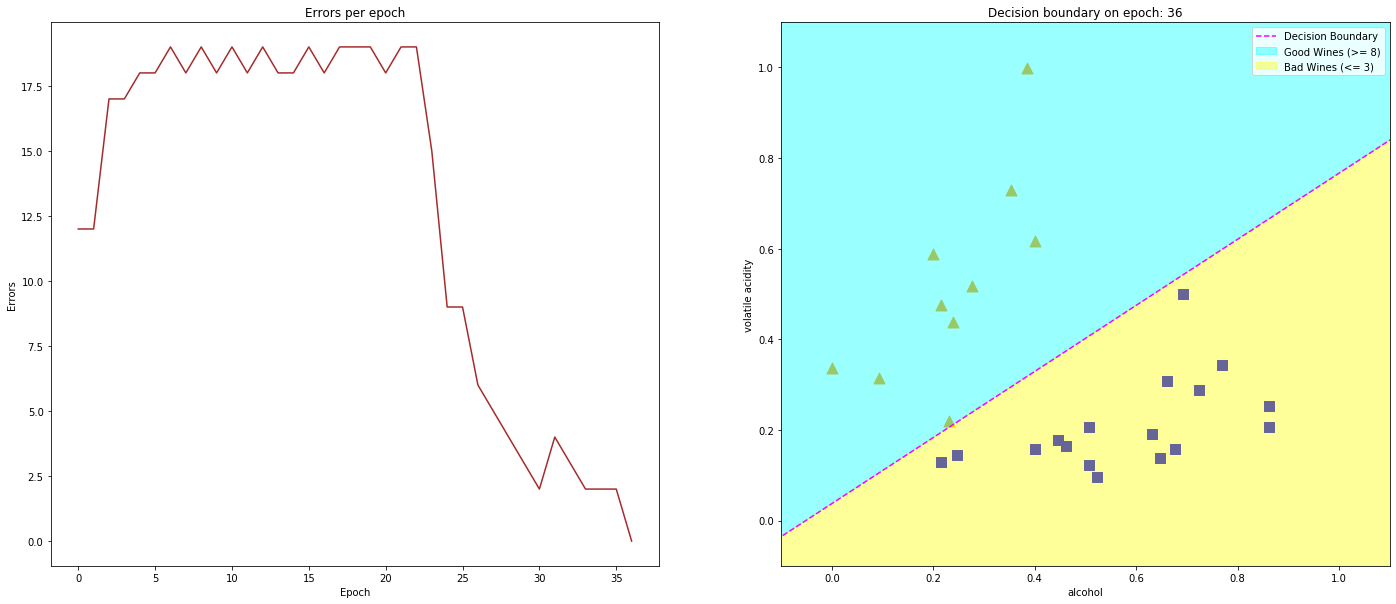

In [66]:
scaled_data = features_scale(red_wine)
X, y = train_split(scaled_data, ('alcohol', 'volatile acidity'), 8, 3)
perceptron = Perceptron(learning_rate=0.01)
performance = perceptron.fit(X, y)
fig = plot_performance(performance, scaled_data, ('alcohol', 'volatile acidity'), 8, 3,
                      save_plot=True, plot_filename='perceptron_with_feature_scaling_performance')

# V.3 My fair ADALINE

### a) Marvin notices and chides you for torturing your perceptron. Why?
Because Perceptron works correctly only if data is perfectly linearly separable. Otherwise, it never stops tring to optimise the weights.

Final number of errors: 32


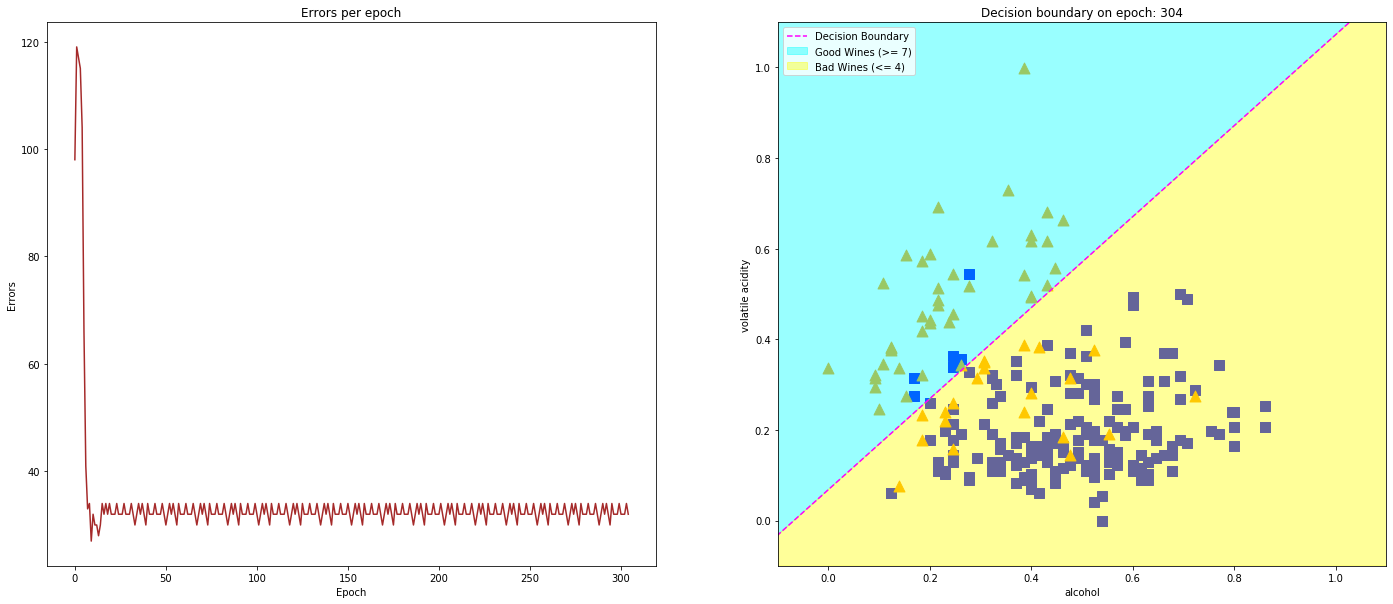

In [69]:
features = ('alcohol', 'volatile acidity')
X, y = train_split(scaled_data, features, 7, 4)
perceptron = Perceptron(learning_rate=0.01, epochs=305)
performance = perceptron.fit(X, y)
print(f"Final number of errors: {performance[-1][1]}")
fig = plot_performance(performance, scaled_data, features, 7, 4, save_plot=True, plot_filename='perceptron_nonseparable_data')

### b)  Implement an ADALINE that:
* Has randomly initialized weights and bias
* Uses a linear activation function and some kind of quantizer
* Uses the Widrow-Hoff learning rule

### c) You’ll need to implement a function to train your ADALINE. Your training function should:
* Take in your red wine data as a parameter
* Have a way to specify number of training epochs
* If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.
* Have a way to specify learning rate.
* Have an option to perform either online learning or batch learning

In [70]:
class Adaline:
    def __init__(self, learning_rate, epochs=0, seed=999):
        """
        Parameters:
            learning_rate: float, speed of weights updating.
            epochs: if 0 then fit works till finds the optimal weights.
            seed: random seed for random function.

        """
        if epochs < 0:
            raise ValueError("Epochs must be more than or equal to zero")
        self._w = None
        self.lr = learning_rate
        self.epochs = epochs
        self.performance = []
        random.seed(seed)
    
    def fit(self, X, y, sgd=False):
        """Train Adaline neuron.

        Parameters:
            X: array with wine chemical elements
            y: vector with qualities equal to 1 if wine is good, otherwise -1
            sgd: if True stochastic gradient descent is used
        Return:
            list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias, SSE)
        It changes weights after each epoch to make more accurate predictions using (stochastic) gradient descent.
        
        """
        epoch = 0
        self.performance.clear()
        self._w = [random.uniform(-1, 1) for _ in range(X.shape[1] + 1)]
        while epoch < self.epochs or self.epochs == 0:
            epoch_errors = [];sum_errors = 0.0
            for xi, target in zip(X, y):
                output = self._activation(xi)
                error = target - output
                sum_errors += error**2
                epoch_errors.append(error)
                if sgd:
                    self._w[1:] += self.lr * error * xi
                    self._w[0] += self.lr * error
            if not sgd:
                self._w[1:] += self.lr * dot(X, epoch_errors)
                self._w[0] += self.lr * sum(epoch_errors)
            clasif_errors = self.get_accuracy(X, y)
            self.performance.append((epoch, clasif_errors, self._w[1:], self._w[0], sum_errors))
            if epoch > 50:
                errors_diff = abs(sum_errors - self.performance[-50][-1])
                if self.epochs == 0 and errors_diff <= 0.005 * sum_errors:
                    break
            epoch += 1
        return self.performance

    def _net_input(self, X):
        return dot(X, self._w[1:]) + self._w[0]

    def _activation(self, X):
        """Linear activation function"""
        return self._net_input(X)
    
    def predict(self, X):
        return 1 if self._activation(X) >= 0 else -1
    
    def get_accuracy(self, X, y):
        errors = 0
        for xi, target in zip(X, y):
            errors += int(self.predict(xi) != target)
        return errors
    
    @classmethod
    def choose_learning_rate(cls, X, y, n_iter, sgd=False, plot=False, columns=None):
        adaline = cls(0, epochs=150, seed=999)
        best_score = None
        best_lr = None
        for _ in range(n_iter):
            lr = round(random.uniform(0.0005, 0.005), 4)
            adaline.lr = lr
            performance = adaline.fit(X, y, sgd)
            if plot:
                fig = plot_performance(performance, scaled_data, columns, 7, 4)
                plt.show(fig)
                print(f"Current learning rate = {lr}")
                print(f"Number of errors: {performance[-1][1]}")
            if best_score is None or best_score > performance[-1][1]:
                best_score = performance[-1][1]
                best_lr = lr
        return best_lr

Final number of errors: 27


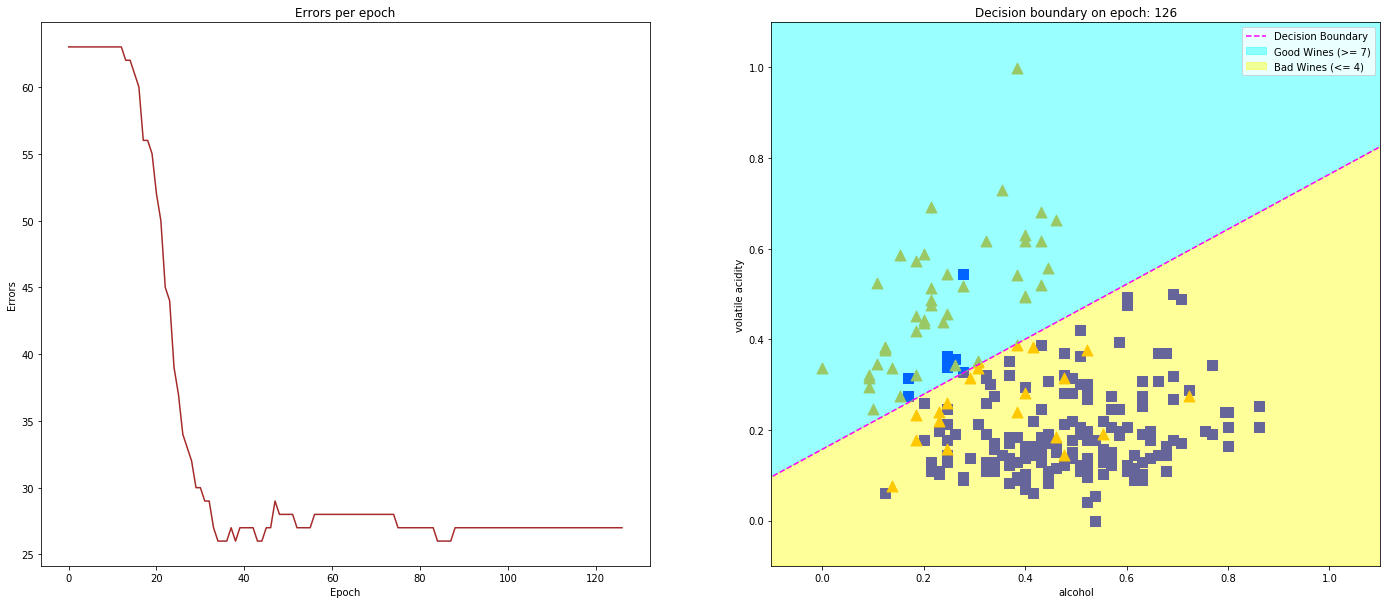

In [72]:
features = ('alcohol', 'volatile acidity')
X, y = train_split(scaled_data, features, 7, 4, binary=False)
adaline = Adaline(0.005, epochs=0)
performance = adaline.fit(X, y, sgd=True)
print(f"Final number of errors: {performance[-1][1]}")
fig = plot_performance(performance, scaled_data, features, 7, 4, save_plot=True, plot_filename='adaline_performance')

### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE.
What settings tend to give the smallest number of classification errors? Support your reasoning with example plots!

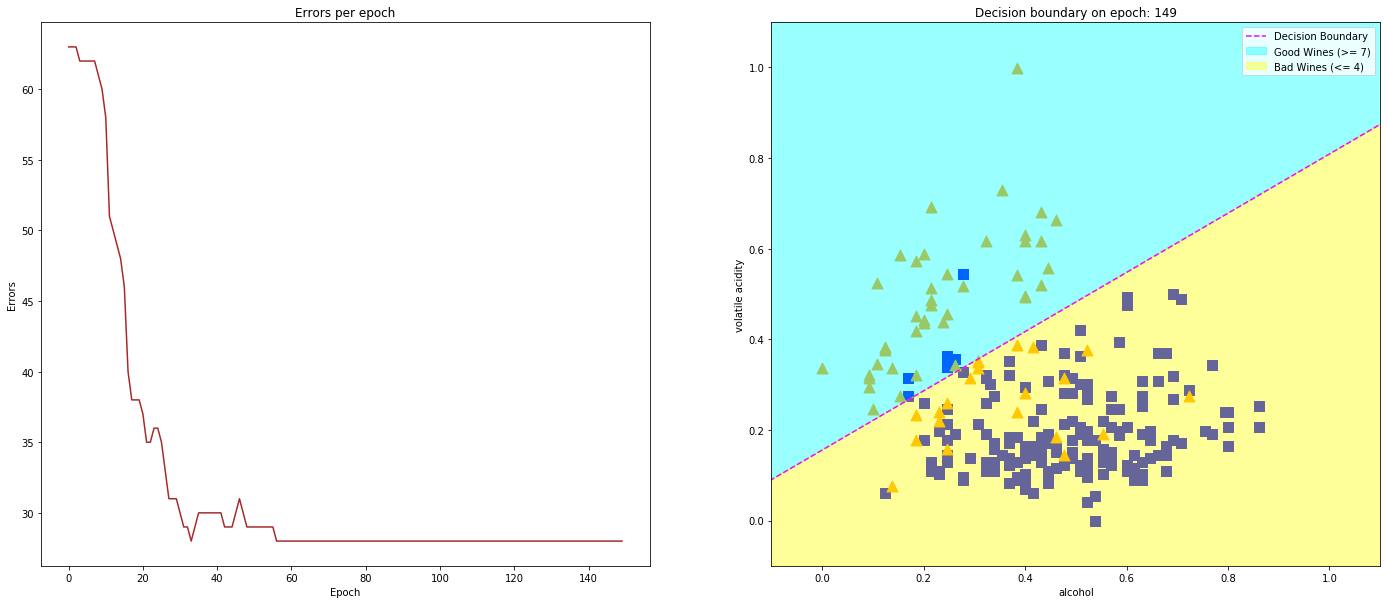

Current learning rate = 0.004
Number of errors: 28


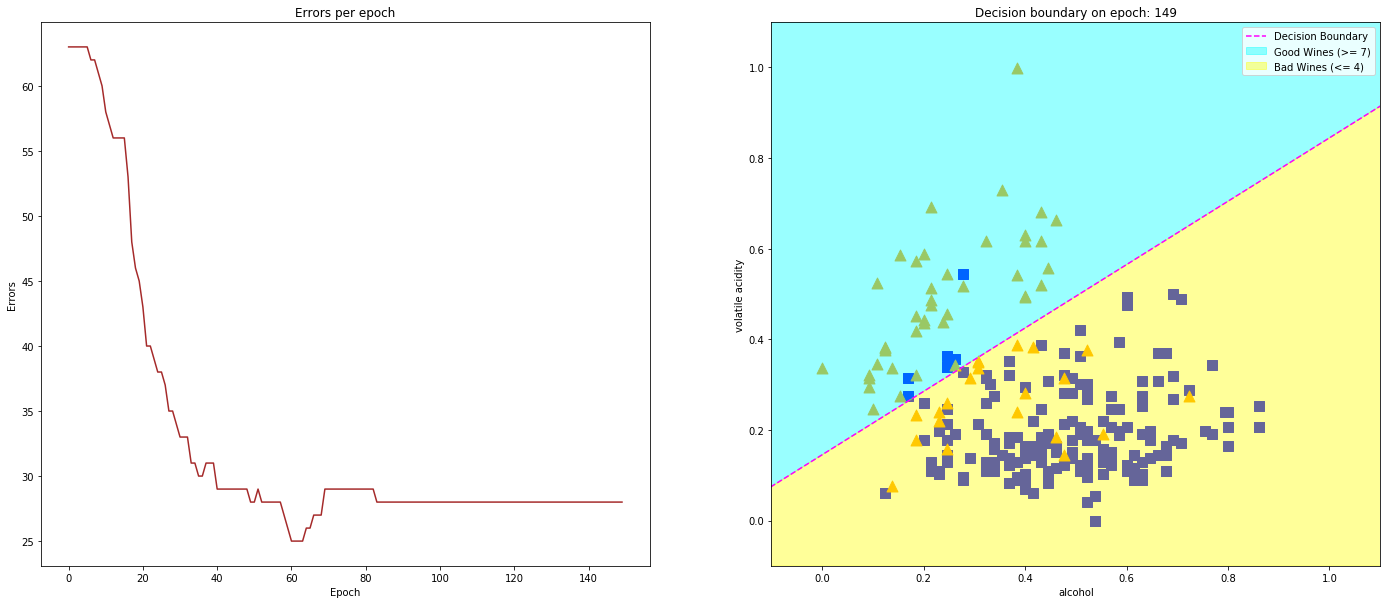

Current learning rate = 0.0027
Number of errors: 28


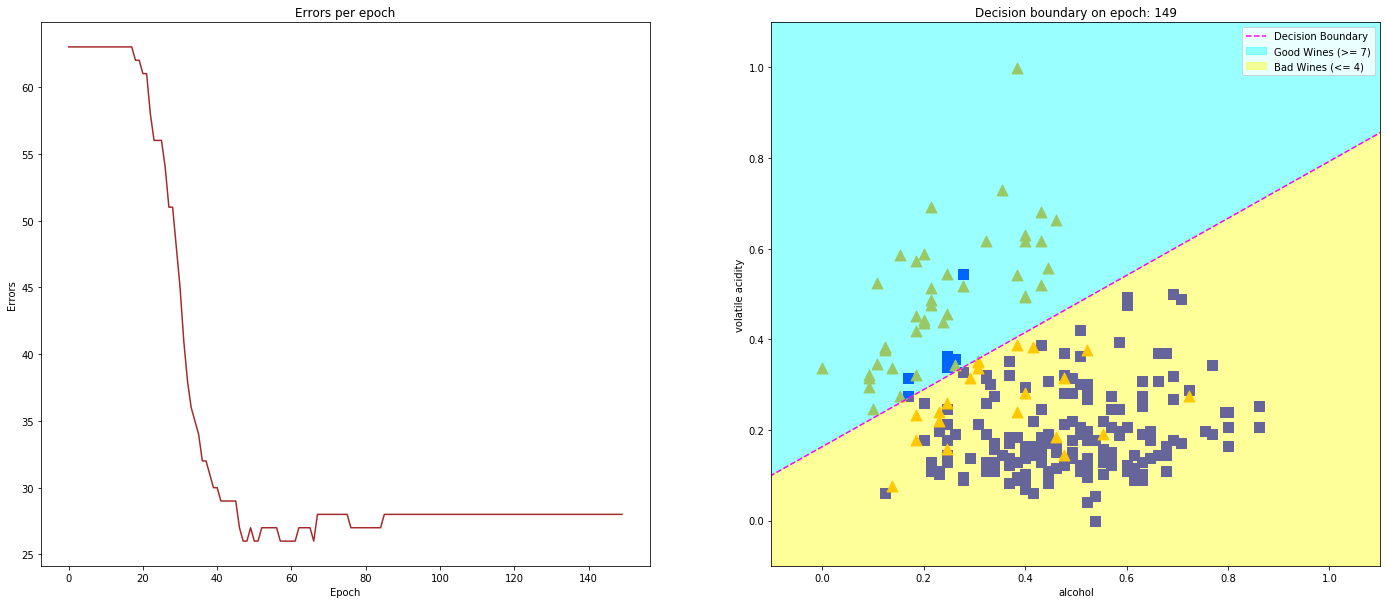

Current learning rate = 0.0041
Number of errors: 28


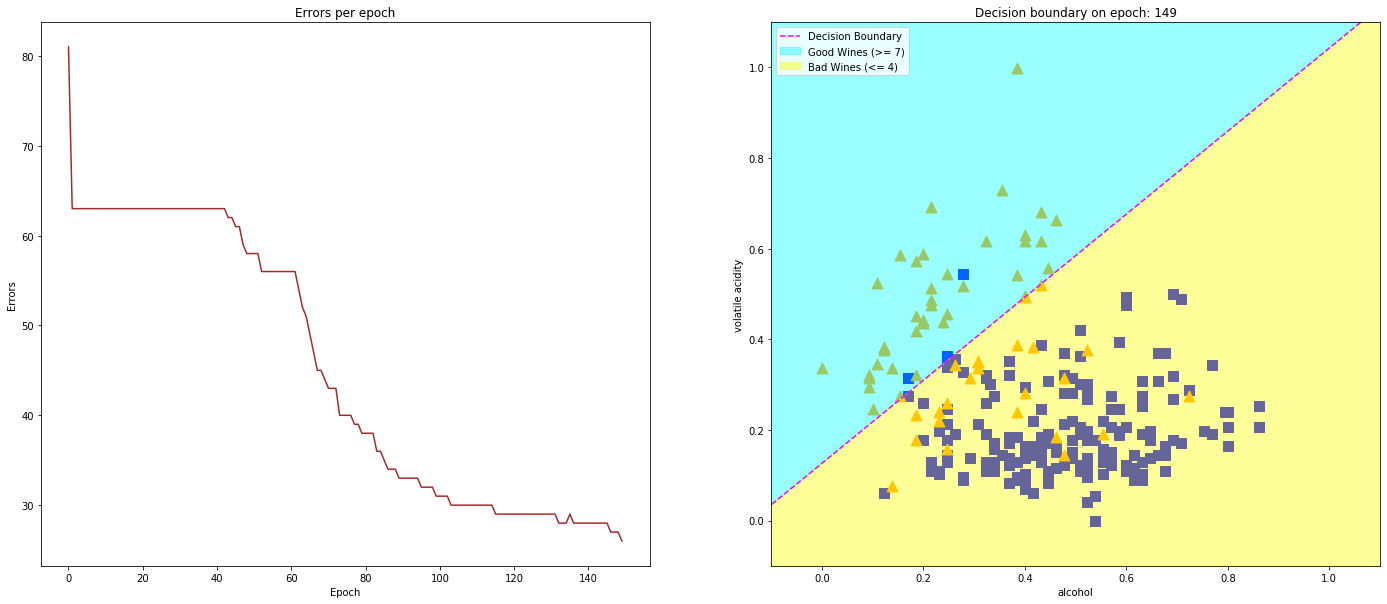

Current learning rate = 0.0013
Number of errors: 26


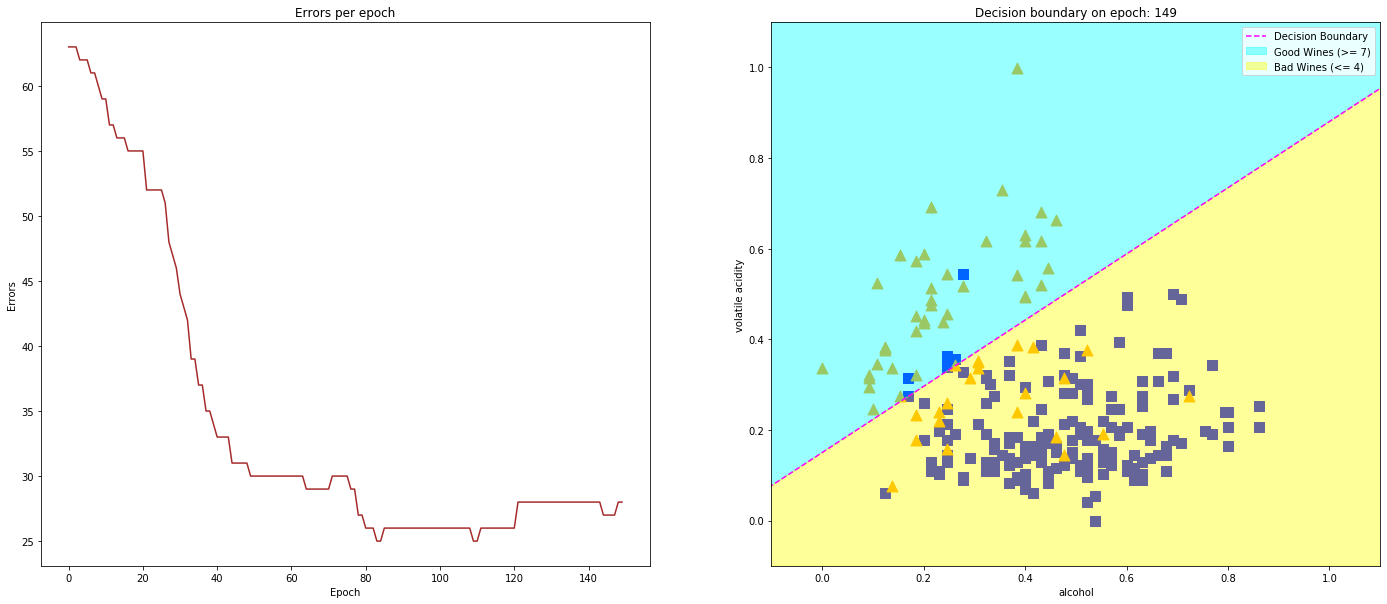

Current learning rate = 0.0016
Number of errors: 28


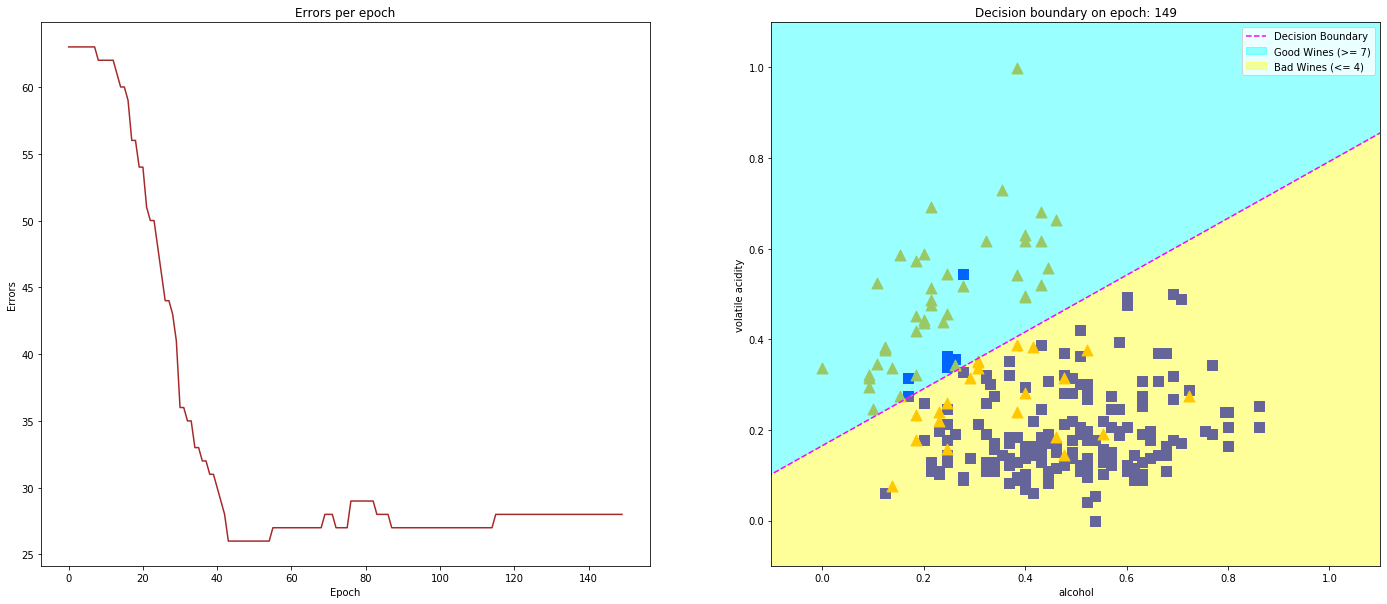

Current learning rate = 0.0033
Number of errors: 28


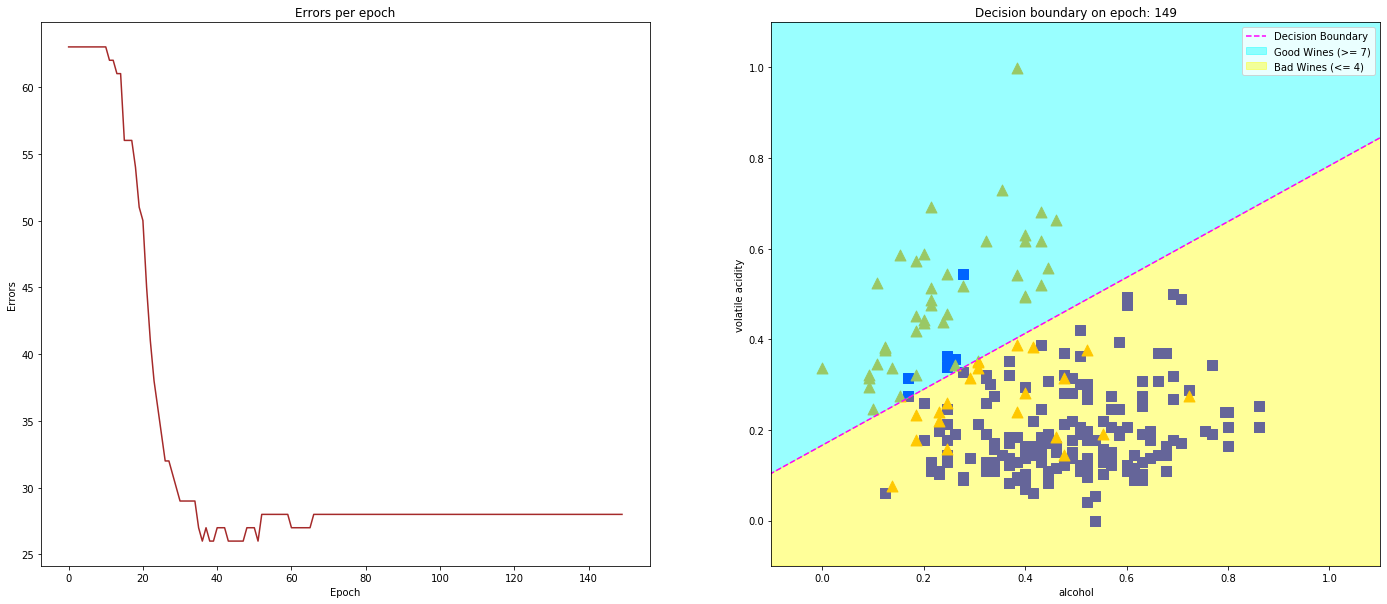

Current learning rate = 0.0049
Number of errors: 28
Best learning rate: 0.0013


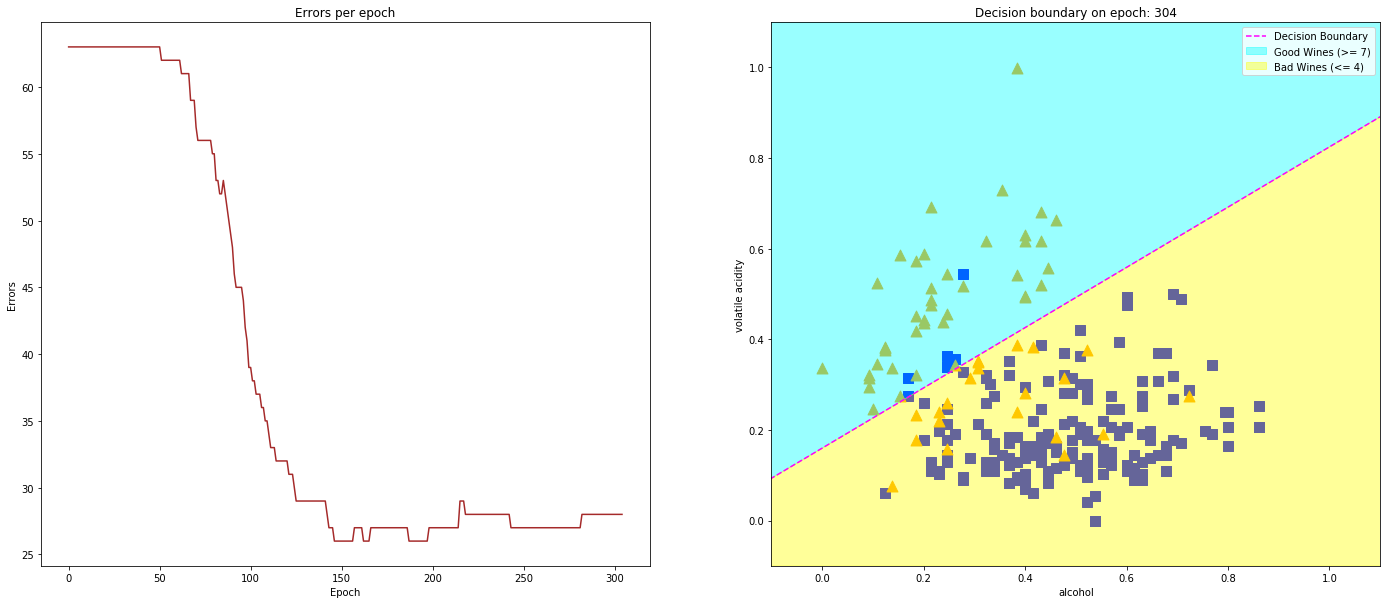

Final number of errors: 28


In [73]:
features = ('alcohol', 'volatile acidity')
X, y = train_split(scaled_data, features, 7, 4, binary=False)
learning_rate = Adaline.choose_learning_rate(X, y, 7, sgd=False, plot=True, columns=features)
print(f"Best learning rate: {learning_rate}")

adaline = Adaline(learning_rate, epochs=0)
performance = adaline.fit(X, y, sgd=False)
fig = plot_performance(performance, scaled_data, features, 7, 4)
plt.show(fig)
print(f"Final number of errors: {performance[-1][1]}")

# V.4 Advanced wine sampling and resampling

### a) Holdout method of cross validation

In [75]:
def train_test_split(wine_data, proportion):
    """Split the dataset into train set and test set

    Parameters:
        wine_data: Pandas Data Frame, chemical elements and quality for wines data set
        proportion: float value from 0 to 1, describing which part of original data set will be a train set
    Return:
        train data set, validation data set

    """
    train_data = wine_data.sample(frac=proportion)
    test_data = wine_data.drop(train_data.index)
    return train_data, test_data

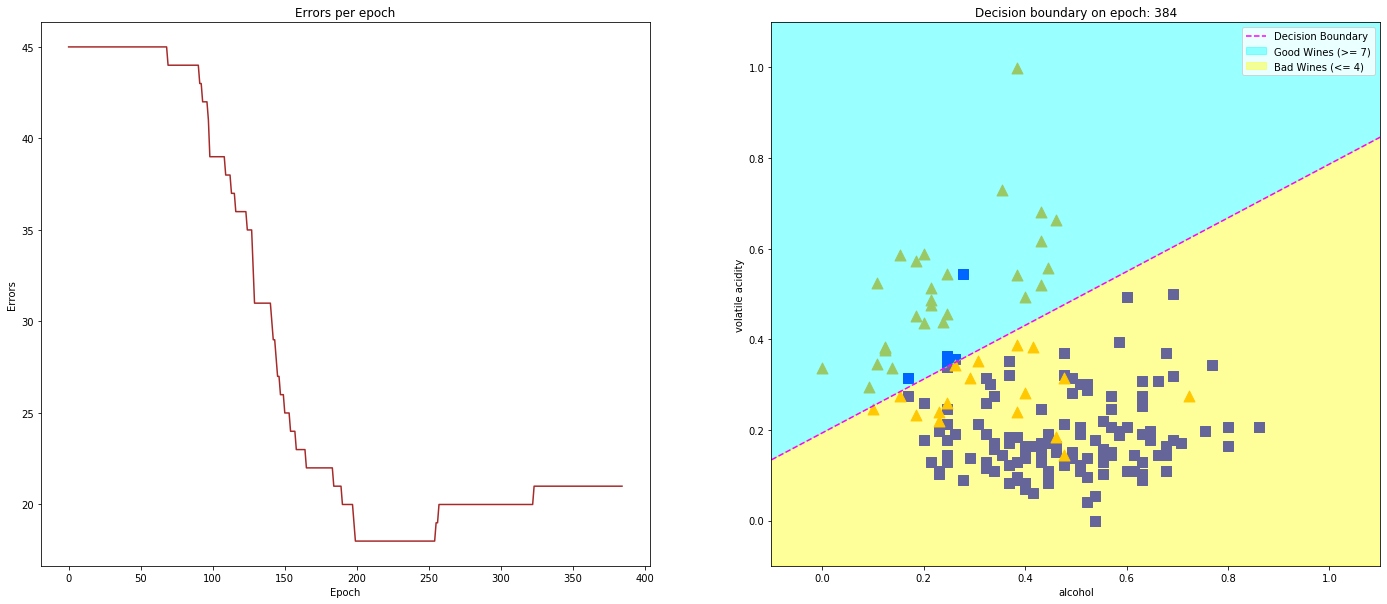

Final number of errors: 21

Number of errors on test data set: 7
Accuracy: 91%


In [80]:
features = ('alcohol', 'volatile acidity')
train, test = train_test_split(scaled_data, 0.75)
adaline = Adaline(learning_rate)
X, y = train_split(train, features, 7, 4, binary=False)
performance = adaline.fit(X, y, sgd=True)
fig = plot_performance(performance, train, features, 7, 4)
plt.show(fig)
print(f"Final number of errors: {performance[-1][1]}\n")

X, y = train_split(test, features, 7, 4, binary=False)
accuracy = adaline.get_accuracy(X, y)
print(f"Number of errors on test data set: {accuracy}")
print(f"Accuracy: {100 - round(accuracy / len(y) * 100)}%")

### b) k-fold cross validation

In [84]:
def k_fold(wine_data, k, shuffle=True):
    """Split the dataset into k folds.

    Parameters:
        wine_data: Pandas Data Frame, chemical elements and quality for wines data set
        k: number of folds
        shuffle: if True shuffle the data before splitting
    Return:
        tuple, containing tuples in format (train_dataset, test_dataset)

    """
    res = []
    if shuffle:
        wine_data = wine_data.sample(frac=1).reset_index(drop=True)
    for fold in (wine_data.iloc[i::k] for i in range(k)):
        train_set = wine_data.iloc[wine_data.index.difference(fold.index)]
        res.append((train_set, fold))
    return tuple(res)

In [85]:
def cross_validation():
    adaline = Adaline(0.005)
    folds = k_fold(scaled_data, 9)
    for fold in folds:
        train, test = fold
        X, y = train_split(train, ['alcohol', 'volatile acidity'], 7, 4, binary=False)
        adaline.fit(X, y)
        X, y = train_split(test, ['alcohol', 'volatile acidity'], 7, 4, binary=False)
        accuracy = adaline.get_accuracy(X, y)
        print(f"Errors num = {accuracy}, Accuracy = {100 - round(accuracy / len(y) * 100)}%")

cross_validation()

Errors num = 2, Accuracy = 91%
Errors num = 3, Accuracy = 91%
Errors num = 4, Accuracy = 89%
Errors num = 2, Accuracy = 94%
Errors num = 0, Accuracy = 100%
Errors num = 4, Accuracy = 89%
Errors num = 5, Accuracy = 82%
Errors num = 4, Accuracy = 88%
Errors num = 4, Accuracy = 86%


# V.5 Adventures in the Nth dimension

### a) Try training your perceptron/adaline with different numbers and types of chemical factors. Under what circumstances can your perceptron/adaline successfully train?
Perceptron can train successfully only if data is perfectly linear separable. Even in n-dimensions. But if we limit the number of cycles, the result is not bad. It's around 95 - 100% accuracy for 8 and 3 rates for wines.

If we set 0 epochs for adaline, it shows good results on 8 and 3 for good and bad wine rates respectively.
It shows 100% accuracy in most cases. For 7 and 4 rated it shows around 80%+ result

For both: perceptron and adaline, it should be more than 1 column to make right predictions

In [86]:
perceptron = Perceptron(0.005, epochs=500)
for i in range(5):
    cols = [col for col in scaled_data.columns if random.getrandbits(1) and col != 'quality']
    X, y = train_split(scaled_data, cols, 8, 3)
    perceptron.fit(X, y)
    accuracy = 100 - round(perceptron.get_accuracy(X, y) / len(y) * 100)
    print(f"Accuracy: {accuracy}% | Columns: {cols}")
print('\n')

train, test = train_test_split(scaled_data, 0.75)
for i in range(5):
    cols = [col for col in scaled_data.columns if random.getrandbits(1) and col != 'quality']
    X, y = train_split(scaled_data, cols, 8, 3, binary=False)
    perceptron.fit(X, y)
    adaline = Adaline(0.005, epochs=0)
    adaline.fit(X, y)
    accuracy = 100 - round(adaline.get_accuracy(X, y) / len(y) * 100)
    print(f"Accuracy: {accuracy}% | Columns: {cols}")

Accuracy: 100% | Columns: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density']
Accuracy: 100% | Columns: ['fixed acidity', 'citric acid', 'residual sugar', 'total sulfur dioxide', 'density', 'pH', 'sulphates']
Accuracy: 100% | Columns: ['volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
Accuracy: 100% | Columns: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'density', 'pH']
Accuracy: 100% | Columns: ['fixed acidity', 'volatile acidity', 'total sulfur dioxide', 'pH', 'alcohol']


Accuracy: 96% | Columns: ['fixed acidity', 'volatile acidity', 'free sulfur dioxide', 'density', 'pH']
Accuracy: 100% | Columns: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
Accuracy: 100% | Columns: ['volatile acidity', 'citric acid'

In [87]:
train, test = train_test_split(scaled_data, 0.75)
random.seed(1488)
for i in range(3):
    cols = [col for col in scaled_data.columns if random.getrandbits(1) and col != 'quality']
    X, y = train_split(scaled_data, cols, 7, 4, binary=False)
    perceptron.fit(X, y)
    adaline = Adaline(0.005, epochs=0)
    adaline.fit(X, y, sgd=True)
    accuracy = 100 - round(adaline.get_accuracy(X, y) / len(y) * 100)
    print(f"Accuracy: {accuracy}% | Columns: {cols}")

Accuracy: 92% | Columns: ['volatile acidity', 'free sulfur dioxide', 'density', 'sulphates', 'alcohol']
Accuracy: 91% | Columns: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
Accuracy: 90% | Columns: ['volatile acidity', 'citric acid', 'residual sugar', 'density', 'pH', 'alcohol']


### b) You know what the decision boundary for 2 wine chemical factors looks like, but what does the decision boundary for 3 factors look like? What about if you use 7 factors? How about if you use all 11 wine chemical factors?
It will be a hyperplane of N - 1 dimensions

# V.6 Marvin’s rebuttal

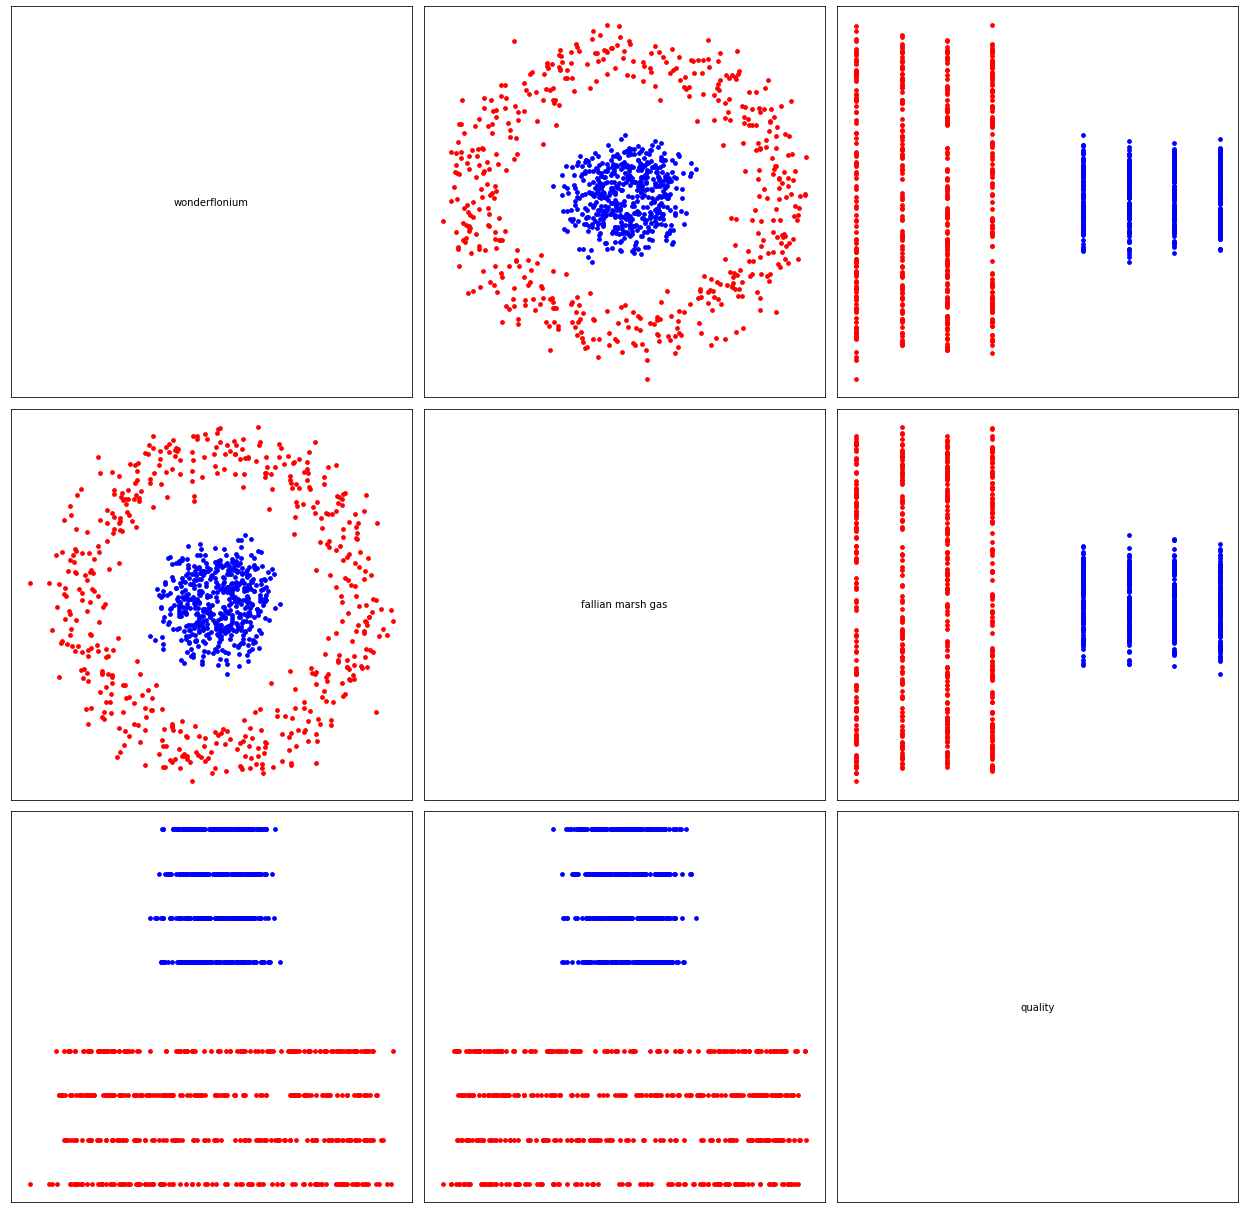

In [88]:
galactic_data = pd.read_csv('Pan Galactic Gargle Blaster.csv', sep=';')
fig = plot_scatter_matrix(galactic_data, 6, 5, save_plot=True, plot_filename='circle_separable_data')

In [89]:
def cart2pol(x, y, center):
    x0, y0 = center
    rho = math.sqrt((x - x0)**2 + (y - y0)**2)
    phi = math.atan2(y, x)
    return (rho, phi)

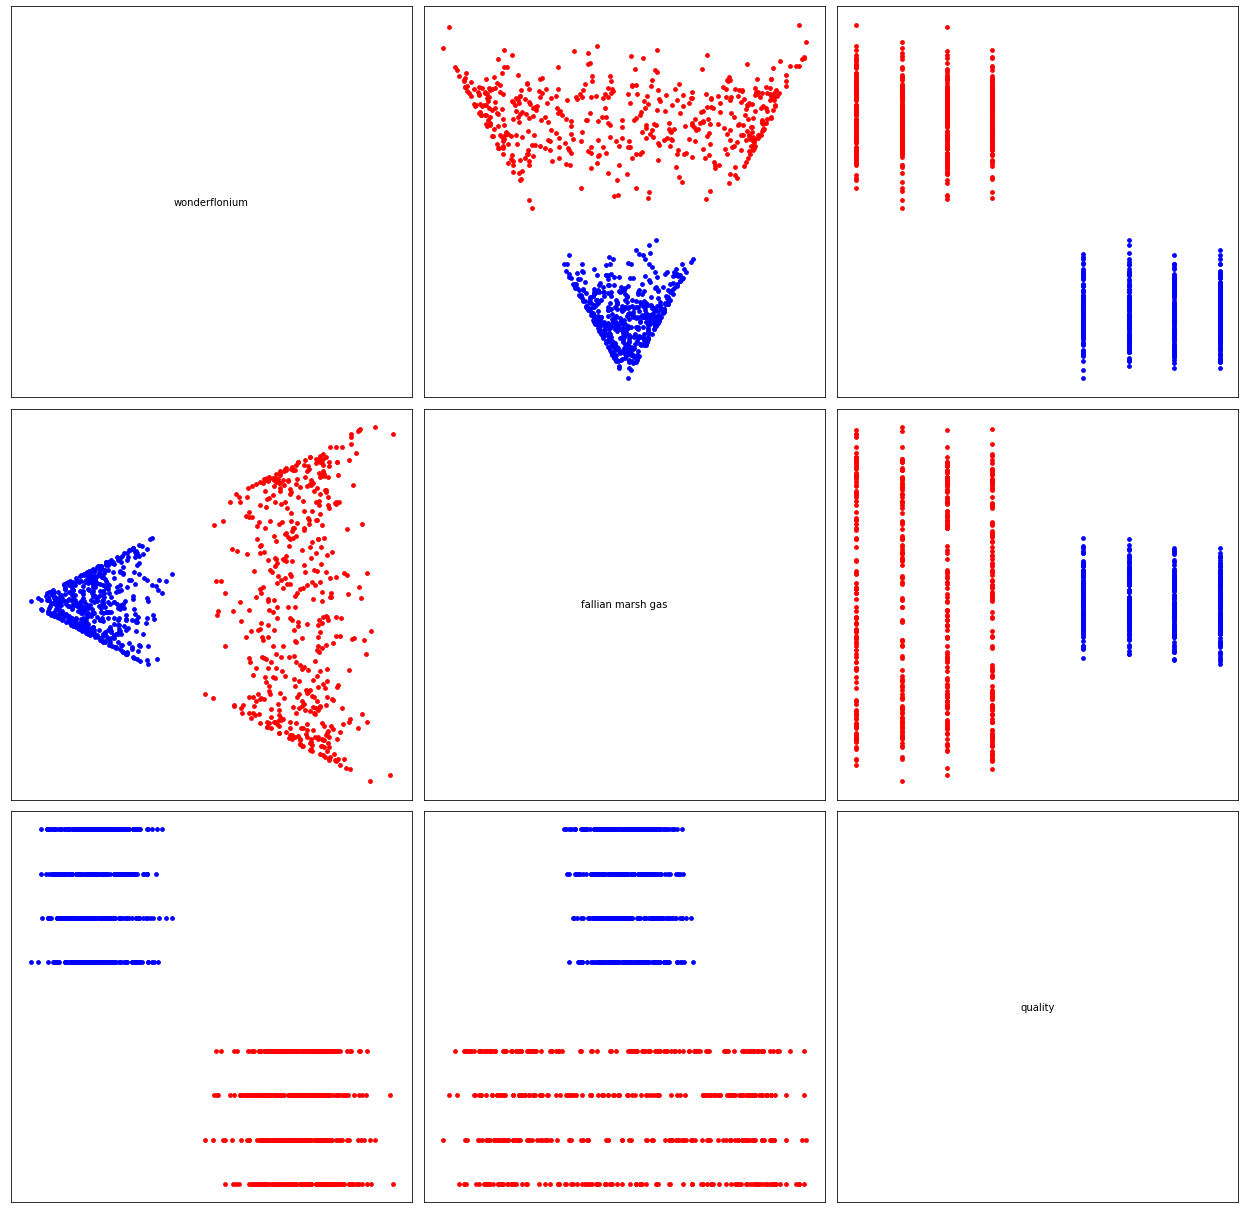

In [91]:
chosen_data = galactic_data[(galactic_data['quality'] >= 5) | (galactic_data['quality'] <= 6)]
bad_data = chosen_data[chosen_data['quality'] <= 5]
x0 = bad_data.iloc[:, 0].mean()
y0 = bad_data.iloc[:, 1].mean()
cols = ['wonderflonium', 'fallian marsh gas']
chosen_data.reset_index(drop=True)
for index, row in chosen_data.iterrows():
    rho, phi = cart2pol(row[0], row[1], (x0, y0))
    chosen_data.loc[index, cols[0]] = rho
    chosen_data.loc[index, cols[1]] = phi
scaled_data = features_scale(chosen_data)
fig = plot_scatter_matrix(scaled_data, 6, 5, save_plot=True, plot_filename='circle_separable_polar_transformation')

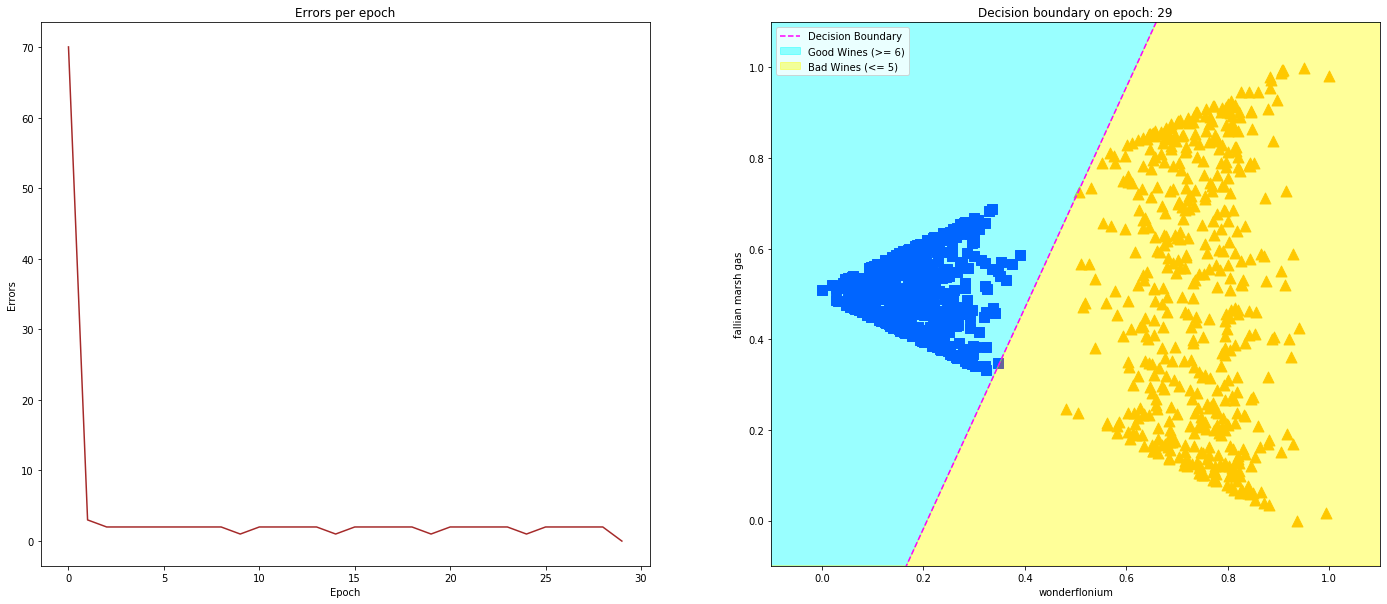

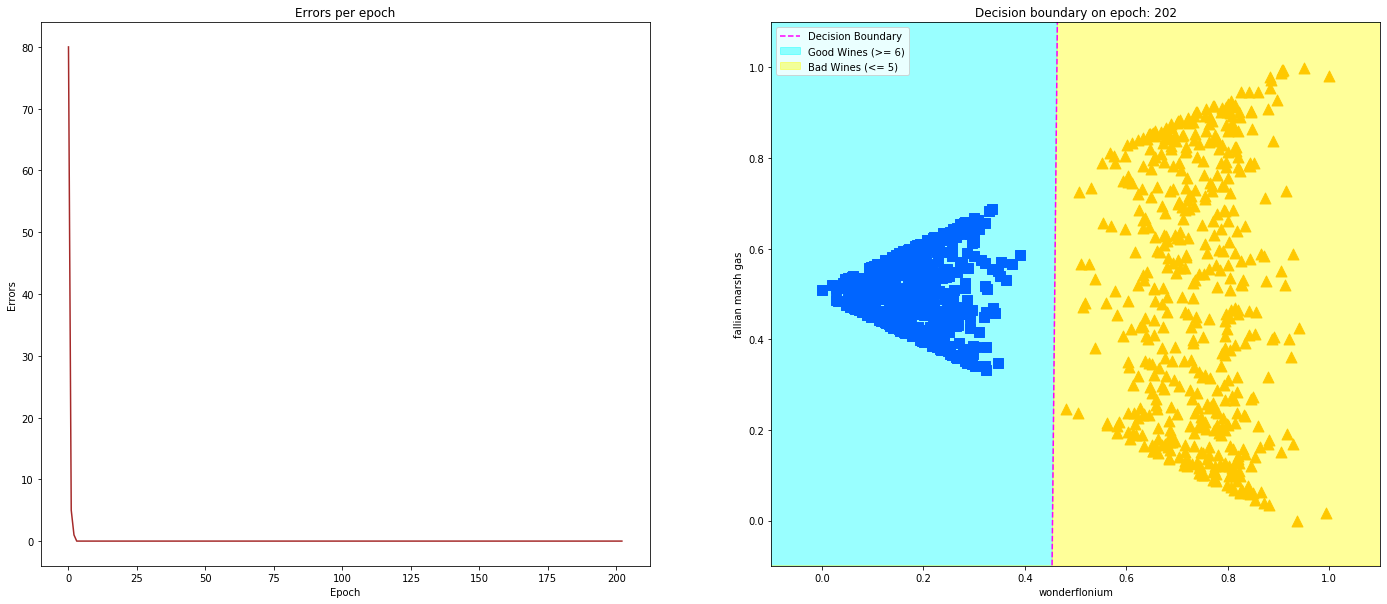

In [92]:
X, y = train_split(scaled_data, cols, 6, 5)
perceptron = Perceptron(0.005)
performance = perceptron.fit(X, y)
fig = plot_performance(performance, scaled_data, cols, 6, 5)
plt.show(fig)

X, y = train_split(scaled_data, cols, 6, 5, binary=False)
adaline = Adaline(0.0005)
performance = adaline.fit(X, y, sgd=False)
fig = plot_performance(performance, scaled_data, cols, 6, 5)
plt.show(fig)

# VI.3 Dimensional traveler

In [94]:
import numpy as np
from mpl_toolkits import mplot3d


def plot_performance_3d(performance, wine_data, features_list, good_thres, bad_thres, *,
                        epoch=-1, save_plot=False, plot_filename='plot_performance3d.png'):
    """Plot perceptron's results in 3d

    Parameters:
        performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
        wine_data: Pandas Data Frame, chemical elements and quality for wines data set
        features_list: list, containing 3 features, used to predict quality
        good_thres: quality of good wines.
        bad_thres: quality of bad wines.
        epoch: epoch to show decision boundary for. It lower than 0 the last epoch is showed.
        save_plot: if True saves the plot as .png

    """
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(projection="3d")
    stat = list(zip(*performance))
    if epoch < 0:
        epoch = len(stat[0]) - 1

    selected_data = wine_data[(wine_data['quality'] >= good_thres) | (wine_data['quality'] <= bad_thres)]
    x_min = selected_data[features_list[0]].min()
    x_max = selected_data[features_list[0]].max()
    y_min = selected_data[features_list[1]].min()
    y_max = selected_data[features_list[1]].max()
    good_wines = selected_data[selected_data['quality'] >= good_thres]
    bad_wines = selected_data[selected_data['quality'] <= bad_thres]
    w1, w2, w3 = stat[2][epoch]
    bias = stat[3][epoch]
    x, y = np.meshgrid(np.linspace(x_min, x_max, 5), np.linspace(y_min, y_max, 5))
    z = (-w1*x - w2*y - bias) / w3
    
    ax.set_title(f"Decision boundary on epoch: {epoch}", size=14)
    ax.set_xlabel(features_list[0], size=12)
    ax.set_ylabel(features_list[1], size=12)
    ax.set_zlabel(features_list[2], size=12)
    ax.scatter(good_wines[features_list[0]], good_wines[features_list[1]], good_wines[features_list[2]], s=120, c='blue')
    ax.scatter(bad_wines[features_list[0]], bad_wines[features_list[1]], bad_wines[features_list[2]], s=120, c='orange', marker='^')
    ax.plot_surface(x, y, z, color='red', alpha=1)

    if save_plot:
        fig.savefig('plot_performance3d.png')
    plt.show(fig)

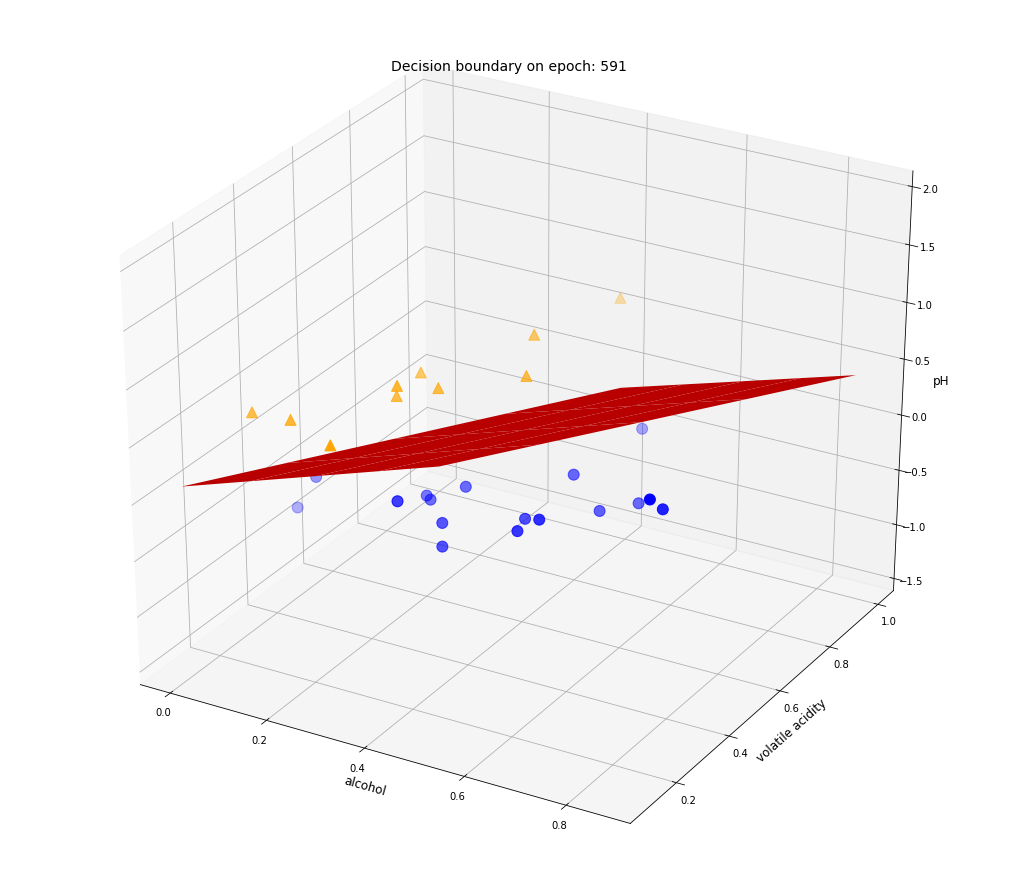

In [98]:
cols = ('alcohol', 'volatile acidity', 'pH')
scaled_data = features_scale(red_wine)
X, y = train_split(scaled_data, cols, 8, 3, binary=False)
adaline = Adaline(0.005)
performance = adaline.fit(X, y)
fig = plot_performance_3d(performance, scaled_data, cols, 8, 3, save_plot=True)